# Facial Emotion Recognition with FER2013

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

2021-09-21 19:56:35.094132: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


## Generating testing and training data

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                    rotation_range=5,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [3]:
train_dataset  = train_datagen.flow_from_directory(directory = '../input/fer2013/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 22968 images belonging to 7 classes.


In [4]:
valid_dataset = valid_datagen.flow_from_directory(directory = '../input/fer2013/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 5741 images belonging to 7 classes.


In [5]:
test_dataset = test_datagen.flow_from_directory(directory = '../input/fer2013/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 7178 images belonging to 7 classes.


## Preprocessing images

(224, 224, 3)
(1, 224, 224, 3)


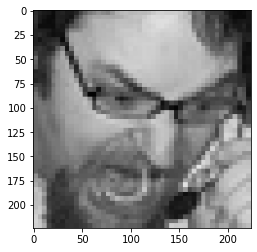

In [6]:
from tensorflow.keras.preprocessing import image
img = image.load_img("../input/fer2013/test/angry/PrivateTest_10131363.jpg",target_size=(224,224))
img = np.array(img)
plt.imshow(img)
print(img.shape)

img = np.expand_dims(img, axis=0)
print(img.shape)

In [7]:
from tensorflow.keras.models import load_model
print(img.shape)

(1, 224, 224, 3)


## Building the Model

### Loading Base Model

In [8]:
base_model = tf.keras.applications.ResNet50(input_shape=(224,224,3),include_top=False,weights="imagenet")

2021-09-21 19:57:12.091258: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-21 19:57:12.094487: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-21 19:57:12.149567: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-21 19:57:12.150205: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-21 19:57:12.150265: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-21 19:57:12.177273: I tensorflow/stream_executor/platform/def

94773248/94765736 [==============================] - 1s 0us/step


In [9]:
for layer in base_model.layers[:-4]:
    layer.trainable=False

### Transfer Learning

In [10]:
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

# number of possible label values
nb_classes = 7

# Initialising the CNN
model = Sequential()

# 1 - Convolution 
# extract relevant features from the images
model.add(base_model) #adding base model of ResNet50
model.add(BatchNormalization())  
model.add(Activation('relu'))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
# using these features to classify 
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 2048)        8192      
_________________________________________________________________
activation (Activation)      (None, 7, 7, 2048)        0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 2048)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 7, 7, 128)         6553728   
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 128)         0

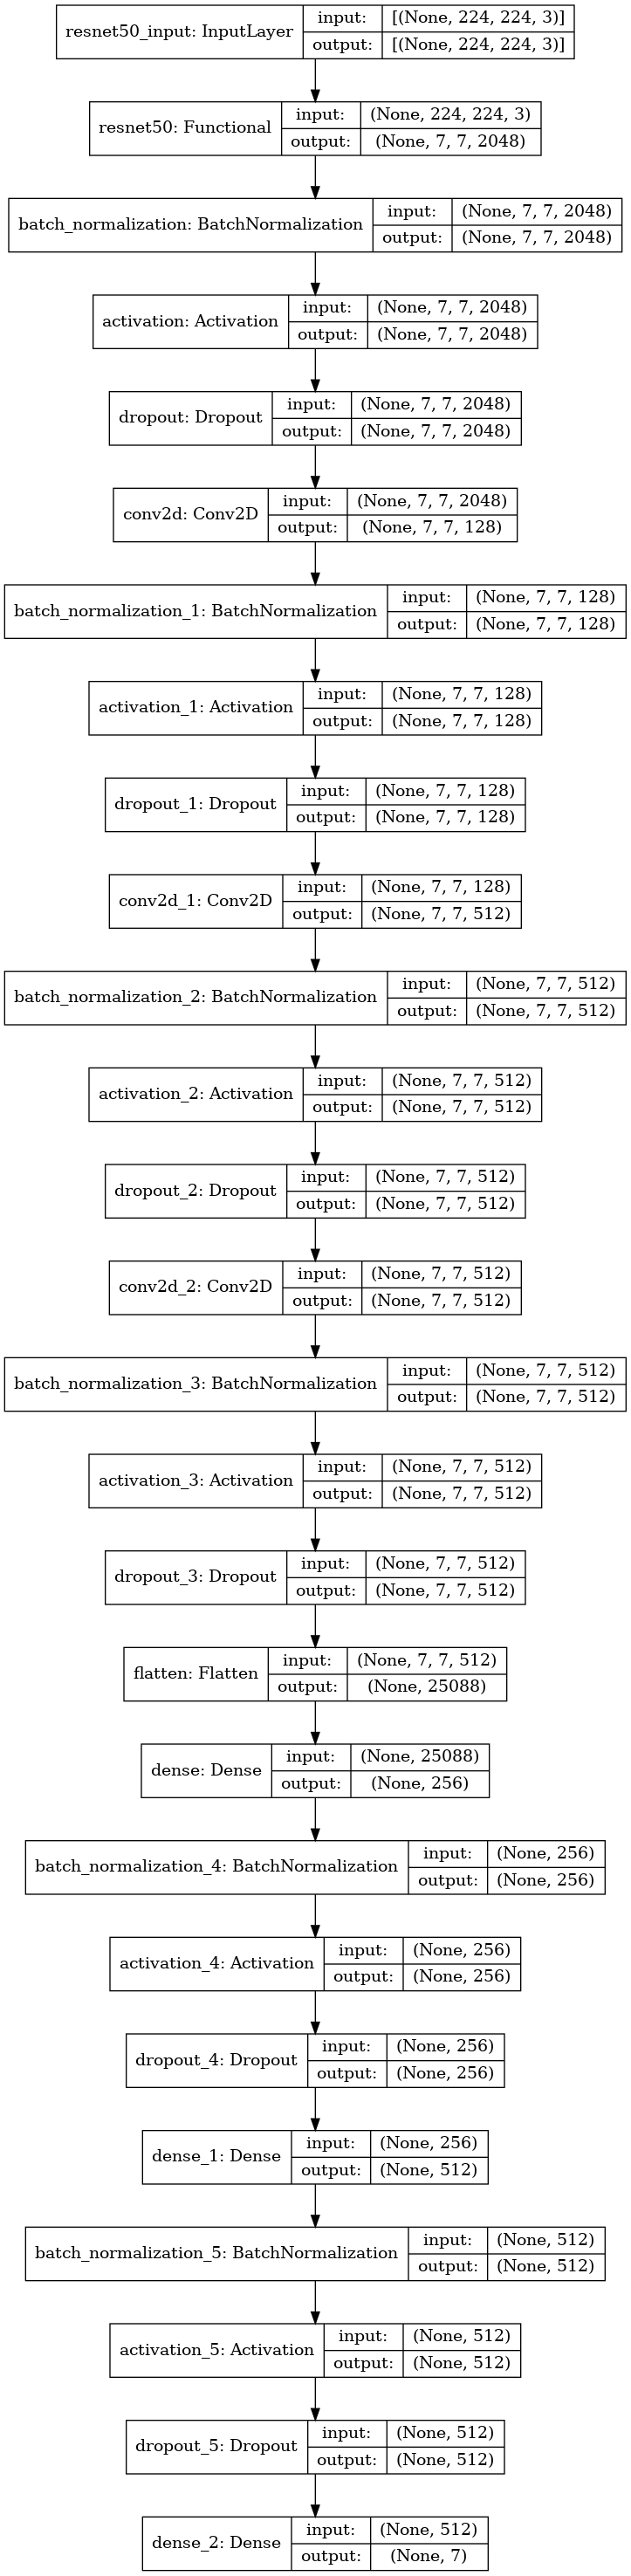

In [12]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='mymodel2.png', show_shapes=True,show_layer_names=True)
Image(filename='mymodel2.png') 

## Model Helper Functions

In [13]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [14]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [15]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('resnet50_mymodel.h5')

es = EarlyStopping(verbose=1, patience=20)

## Compiling and Training model

In [16]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [17]:
import tensorflow.keras.backend as K
from tensorflow.keras.applications.nasnet import NASNetLarge

history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 30,verbose = 1,callbacks=[lrd,mcp,es])

2021-09-21 19:57:19.337802: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-21 19:57:19.341613: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000165000 Hz


Epoch 1/30


2021-09-21 19:57:23.876533: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-21 19:57:24.732377: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-09-21 19:57:24.963948: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


359/359 [==============================] - 416s 1s/step - loss: 2.0620 - accuracy: 0.8440 - precision: 0.2023 - recall: 0.0311 - auc: 0.6057 - f1_score: 0.0509 - val_loss: 1.9208 - val_accuracy: 0.8508 - val_precision: 0.1636 - val_recall: 0.0108 - val_auc: 0.6295 - val_f1_score: 0.0203
Epoch 2/30
359/359 [==============================] - 294s 818ms/step - loss: 1.8621 - accuracy: 0.8549 - precision: 0.1992 - recall: 0.0050 - auc: 0.6434 - f1_score: 0.0098 - val_loss: 2.3177 - val_accuracy: 0.8301 - val_precision: 0.1895 - val_recall: 0.0577 - val_auc: 0.5585 - val_f1_score: 0.0879
Epoch 3/30
359/359 [==============================] - 299s 833ms/step - loss: 1.8408 - accuracy: 0.8556 - precision: 0.2677 - recall: 0.0060 - auc: 0.6493 - f1_score: 0.0116 - val_loss: 1.9395 - val_accuracy: 0.8524 - val_precision: 0.1968 - val_recall: 0.0108 - val_auc: 0.6052 - val_f1_score: 0.0201
Epoch 4/30
359/359 [==============================] - 301s 840ms/step - loss: 1.8250 - accuracy: 0.8551 - pr

## Plotting Presults

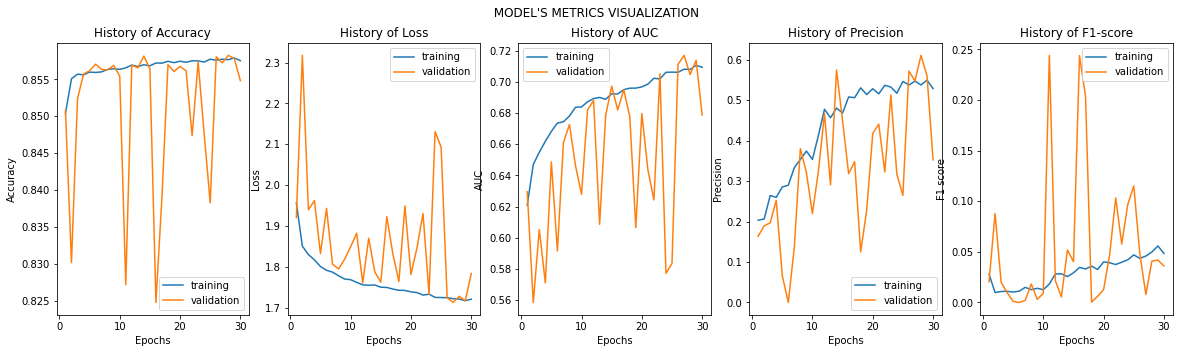

In [18]:
## plotting Results

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

## Testing Accuracy

In [19]:
y_pred = model.predict(test_dataset)

In [20]:
print(y_pred)

[[0.12013814 0.01128865 0.18093595 ... 0.12667188 0.38833532 0.05311404]
 [0.18398777 0.01406965 0.14582044 ... 0.18003137 0.26471293 0.055317  ]
 [0.1819757  0.01073854 0.14292914 ... 0.22076163 0.17507826 0.10742029]
 ...
 [0.12441793 0.01002481 0.19080581 ... 0.1056696  0.40450084 0.04855622]
 [0.10741598 0.00841251 0.22989082 ... 0.12063443 0.1409146  0.29994053]
 [0.12193585 0.01615691 0.19338603 ... 0.15204765 0.24965385 0.10693613]]


In [21]:
test_acc = model.evaluate(test_dataset, verbose=2)
print(test_acc)

113/113 - 17s - loss: 1.7746 - accuracy: 0.8555 - precision: 0.3916 - recall: 0.0209 - auc: 0.6810 - f1_score: 0.0388
[1.7746306657791138, 0.8554909229278564, 0.3916448950767517, 0.020897185429930687, 0.681015133857727, 0.038801711052656174]


## Testing with custom image

(224, 224, 3)
(1, 224, 224, 3)


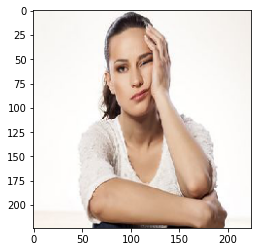

In [22]:
img = image.load_img("../input/testimages/bored.jpg",target_size=(224,224))
img = np.array(img)
plt.imshow(img)
print(img.shape)

img = np.expand_dims(img, axis=0)
print(img.shape)

In [23]:
prediction = model.predict(img)
print(np.argmax(prediction))

6


(224, 224, 3)
(1, 224, 224, 3)


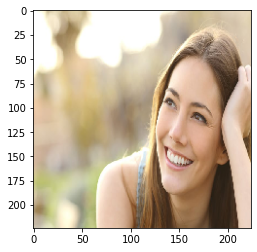

In [24]:
img2 = image.load_img("../input/testimages/engaged.jpg",target_size=(224,224))
img2 = np.array(img2)
plt.imshow(img2)
print(img2.shape)

img2 = np.expand_dims(img2, axis=0)
print(img2.shape)

In [25]:
prediction = model.predict(img2)
# print(np.argmax(prediction))
pred = np.argmax(prediction)
print(pred)

3
